# Temporal Visualization

Python 3.5

In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import os, sys, imp
import re
import random
import nltk
tokenizer = nltk.tokenize.treebank.TreebankWordTokenizer()
import string
import datetime
import imp
import math
import warnings

# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Network Analysis
import igraph
import scipy.spatial.distance as ssd

# Clustering
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from nltk.corpus import stopwords
from scipy.cluster.hierarchy import fcluster
from statistics import mean

In [2]:
warnings.filterwarnings("ignore")

In [3]:
punctuation = set(string.punctuation)

In [4]:
os.chdir('..') # Change to Top Level GIT Directory

In [6]:
pwd

'/Users/hopeemac/Documents/Code/GIT/DSI_Religion'

In [7]:
sys.path.append('./prototype_python') # Add location of python prototype to path

In [8]:
sys.path.append('./protest_temporalAnalysis/') # Add location of python prototype to path

In [9]:
import temporal_methods as tm
import semanticDensity as sd
import syntacticParsing as sp

## -- Set up Parameters for Analysis --

group = 'DorothyDay'
plotstart = '1933-01-01'
plotend = '1981-01-01'
plotfilename = 'DorothyDay_temporal.pdf'
saveplot = True

group = 'WBC'
plotstart = '2007-01-01'
plotend = '2016-01-01'
plotfilename = 'WBC_temporal.pdf'
saveplot = True

In [10]:
group = 'MLK'
plotstart = '1954-01-01'
plotend = '1969-01-01'
plotfilename = 'MLK_temporal.pdf'
saveplot = True

group = 'Ghandi'
plotstart = '1915-01-01'
plotend = '1949-01-01'
plotfilename = 'Ghandi_temporal.pdf'
saveplot = True

### Read in Sample of News Articles

In [11]:
articleLoc = './protest_temporalAnalysis/generic_text/NYT_GerberSample/news_documents.xml'

In [12]:
data = tm.parse_xml(articleLoc, 'doc', ['id','t','d','c'])

In [13]:
data.columns = ['id','title','date','content']

In [14]:
# Tokenize and Clean News Articles
newsTokenLists = {data.loc[rowID,'id']: tokenizer.tokenize(data.loc[rowID,'content']) for rowID in range(0,len(data))}
newsTokenLists = {data.loc[rowID,'id']: tm.clean_text(newsTokenLists[data.loc[rowID,'id']]) for rowID in range(0,len(data))}

### Build Metadata File for Analysis Text

In [15]:
if group == 'DorothyDay':
    dataloc = './protest_temporalAnalysis/data_activists/DorothyDay/raw/'
    fileData = tm.getDorothyDaymetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1933-05-01 00:00:00 1980-10-01 00:00:00

In [16]:
if group == 'WBC':
    dataloc = './data_dsicap/WBC/raw/'
    fileData = tm.getWBCmetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 2007-05-27 00:00:00 2015-09-20 00:00:00

In [17]:
if group == 'MLK':
    dataloc = './protest_temporalAnalysis/data_activists/MLK/raw/'
    fileData = tm.getSimplemetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1954-02-28 00:00:00 1968-03-31 00:00:00

1954-02-28 00:00:00 1968-03-31 00:00:00


In [18]:
if group == 'Ghandi':
    dataloc = './protest_temporalAnalysis/data_activists/Ghandi/raw/'
    fileData = tm.getSimplemetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1915-04-21 00:00:00 1948-01-12 00:00:00

In [19]:
# Tokenize and clean all files in the metadata dataframe, returns a dict
tokenLists = {file: tm.tokenize34(dataloc,file) for file in fileData.fileName}
tokenLists = {file: tm.clean_text(tokenLists[file]) for file in fileData.fileName}

In [20]:
# Removes files shorter than 100 words, not required
shortfiles = []
for i in range(len(fileData)):
    if len(set(tokenLists[fileData.loc[i,'fileName']])) < 100:
        # print('problem'+file)
        shortfiles.append(i)
print(shortfiles)
fileData.drop(shortfiles, inplace=True)

[]


### Read in Event Data

In [21]:
# Only reading in Civil Rights Dates

In [22]:
dates = pd.read_excel('./protest_temporalAnalysis/CivilRightsMovement_Dates.xlsx')

In [23]:
d = dates[dates.Type == 'Death']

### Document Level - Word Count Signals

In [24]:
# Get signal relating to how many words in each file. More of a check to understand major
# differences between files

In [25]:
counts = [tm.count_words(tokenLists[file]) for file in fileData.fileName]
fileData['wordcount'] = counts

In [26]:
# Number of times the word 'protest is used -- words 'protest' and 'god' are arbitrary
protest = [tm.count_specific_words(tokenLists[file], 'protest') for file in fileData.fileName]
fileData['protest_word'] = protest

In [27]:
god = [tm.count_specific_words(tokenLists[file], 'god') for file in fileData.fileName]
fileData['god'] = god

### Document Level - Semantic Density Signal w/ News

Updates to context vector semantic density algorithm for document level analysis: 
- create DSM from external source (i.e. set of news articles) instead of bin being analyzed
- context vectors are made occurrence of target word in single document with distribution from generic DSM
- updated algo to not make/store context vectors unless in target word list
- had to account for words in the document, but not in the DSM (smoothing) * not complete, now returns all 0's
- updated algo to return # of times target words shows up in the document, to help check for bias in small # of occurences of search word in document

In [28]:
#Get word coCo for News Articles/Generic Text Dataset
# CoCo, TF, docTF = sd.coOccurence(newsTokenLists,k=2)
#Get DSM for News Articles
# DSM=sd.DSM(CoCo,100)

In [29]:
#Get word coCo from all Documents in current group's textset
# Need token list in dict with filenames as keys
CoCo, TF, docTF = sd.coOccurence(tokenLists,k=2)
#Get DSM for News Articles
DSM=sd.DSM(CoCo,100)

In [30]:
semanticDensity=[]
for file in fileData.fileName:
    print(file)
    CVDict=tm.contextVectors(tokenLists[file], DSM, ['the'], 2)
    cosineSimilarity=tm.averageCosine(CVDict,simCount=10000)
    avgSD=np.mean([x[1] for x in cosineSimilarity])
    semanticDensity = semanticDensity+[avgSD]

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [31]:
fileData['semanticDensity_the'] = semanticDensity

In [32]:
# Make a dictionary with the list of Top 10 Adj/Adv for each document, will be reused
targetwords = {}
for file in fileData.fileName:
    targetwords[file] = sp.targetWords(tm.getRawText(dataloc,file),wordCount=10,startCount=0)

In [33]:
semanticDensity=[]
for file in fileData.fileName:
    print(file)
    # targetwords = sp.targetWords(tm.getRawText(dataloc,file),wordCount=10,startCount=0)
    CVDict=tm.contextVectors(tokenLists[file], DSM, targetwords[file], 2)
    cosineSimilarity=tm.averageCosine(CVDict,simCount=10000)
    avgSD=np.mean([x[1] for x in cosineSimilarity])
    semanticDensity = semanticDensity+[avgSD]

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [34]:
fileData['semanticDensity_adjadv'] = semanticDensity

### Document-Level Sentiment

Updates to Sentiment algorithm for document level analysis: 
- % pos/neg words by document instead of averaged over bin
- don't have signal of % pos/neg documents per bin bc not relevant to single-document analysis

In [35]:
start=datetime.datetime.now()
sentiment=[]
for file in fileData.fileName:
    print(file)
    sent = tm.sentimentLookup(tokenLists[file])
    sentiment.append(sent) # Returns %pos, %neg, #pos, #
print(datetime.datetime.now()-start)

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [36]:
# Extracts the %pos from the returned tuple
s=[sent[0][0] for sent in sentiment]
fileData['sentiment_pos']=s

In [37]:
# Extracts the %neg from the returned tuple
s=[sent[0][1] for sent in sentiment]
fileData['sentiment_neg']=s

### Document-Level Network Analysis

Updates to network algorithm for document level analysis: 
- Using Top 10 (or less) Adj/Adv from the Single Document for analysis (maybe should switch this?)

In [38]:
#Define functions
def getNetworkQuant(dsm,targetWords,netAngle):
    
    #Get list of values in DSM
    dsmList=[list(dsm[key].values()) for key in dsm.keys()]
    # print(dsmList)
    #Calculate distances for each set of values in dsm
    cosineNP=ssd.cdist(dsmList,dsmList,metric='cosine')
    
    adj = cosineNP.copy()
    
    #Apply thresholds
    adj[np.abs(cosineNP) >= math.cos(math.radians(netAngle))] = 0 # Converting 30 degree threshold to radians to a cosine value
    
    adj[np.abs(cosineNP) < math.cos(math.radians(netAngle))] = 1 # Converting 30 degree threshold to radians to a cosine value
    
    adjList = pd.DataFrame(adj,columns=dsm.keys(),index=dsm.keys()).values.tolist()
    
    #Create network graph
    net = igraph.Graph.Adjacency(adjList, mode = "undirected")
    
    #Get eigenvector centrality
    ev_centrality = igraph.Graph.evcent(net)
    
    # ** Double Check this Subseting ** #
    #Get mean eigenvector centrality for words in target list
    meanEVC=np.mean([ev_centrality[i] for i in range(len(dsm.keys())) if list(dsm.keys())[i] in targetWords])
    return(meanEVC)

In [39]:
network=[]
for file in fileData.fileName:
    print(file)
    #Get word coCo for Single Document
    CoCo, TF, docTF = sd.coOccurence({file: tokenLists[file]},k=2)
    #Get DSM for Single Document
    DSM=sd.DSM(CoCo,100)
    result=getNetworkQuant(DSM,targetwords[file],30)
    network.append(result)

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [40]:
fileData['network']=network

### Document-Level Subgraph Centrality

#### Warning: Function to acquire this metric not accurate/complete

In [41]:
#Define functions
def getSubgraphCent(dsm,targetwords,netAngle):
    # Get index location of Target Word, will match the vertex in the graph
    targetindex = []
    for word in targetwords:
        targetindex.append(list(dsm.keys()).index(word))
    
    #Get list of values in DSM
    dsmList=[list(dsm[key].values()) for key in dsm.keys()]
    # print(dsmList)
    #Calculate distances for each set of values in dsm
    cosineNP=ssd.cdist(dsmList,dsmList,metric='cosine')
    
    adj = cosineNP.copy()
    
    #Apply thresholds
    adj[np.abs(cosineNP) >= math.cos(math.radians(netAngle))] = 0 # Converting 30 degree threshold to radians to a cosine value
    
    adj[np.abs(cosineNP) < math.cos(math.radians(netAngle))] = 1 # Converting 30 degree threshold to radians to a cosine value
    
    adjList = pd.DataFrame(adj,columns=dsm.keys(),index=dsm.keys()).values.tolist()
    
    #Create network graph
    graph = igraph.Graph.Adjacency(adjList, mode = "undirected")
    
    # Get measure of the centrality of the subgraph containing only the target words
    subgraph = igraph.Graph.subgraph(graph, targetindex)
    centrality = sum(subgraph.betweenness()) / len(targetindex)

    return(centrality)

### Document-Level Judgements

Updates to Judgements algorithm for document level analysis: 
- percent of judgements is based on a 1 document, not the average of all documents in bin
- only using % judgements, not raw count of number of judgement sentences

In [42]:
import syntacticParsing as sp

In [43]:
judgements=[]
for file in fileData.fileName:
    print(file)
    rawText = tm.getRawText(dataloc,file)
    percent=sp.judgements(rawText)
    judgements.append(percent)
    #judgementAvg=list(np.mean(np.array(judgementList),axis=0))

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [44]:
j=[judge[1] for judge in judgements]
fileData['judgements']=j

### Document-Level Word Usage Calculation from Clusters

In [45]:
#Define function to create context vectors
def make_coOcVectors_TFdict(tokenList,wordlist,k):
    'Returns vectors of words within window for each occurrence of word in wordlist'
    
    #Define coOccurence dict
    cvDict={}

    for i in range(len(tokenList)):
        targetword=tokenList[i] # Changed window to targetword for more clarity
        
        if targetword in wordlist:
            # print(targetword)
            #Adjust window to contain words k in front or k behind
            lowerBound=max(0,i-k)
            upperBound=min(len(tokenList),i+k)
            cvList=tokenList[lowerBound:i]+tokenList[i+1:upperBound+1]
    
            if targetword not in cvDict.keys():
                cvDict[targetword]={}
            
            #Add context vector to cvDict
            cvIndex=len(cvDict[targetword])+1
            cvDict[targetword][cvIndex]={}
            
            for word in cvList:
                if word in cvDict[targetword][cvIndex]:
                    cvDict[targetword][cvIndex][word] += 1
                else:
                    cvDict[targetword][cvIndex][word] = 1
    
    #Return context vector dictionary
    return(cvDict)

In [46]:
def getWordUsage(tokenlist,targetwords,windowSize):
    # Make sure 'nt' converted to 'not' in target word list
    targetwords = [word for word in targetwords if word != 'nt']
    
    coOc_TFdict=make_coOcVectors_TFdict(tokenlist, targetwords, windowSize)
   
    # Distance Threshold for Cluster Cutoff
    max_d = 2.0

    cluster_count = []
    cluster_count_norm = []

    for target in targetwords:
        # Covert Dict of Co-Occurrances to DTM
        coCoDictList = []
        for key in coOc_TFdict[target].keys():
            coCoDictList.append(coOc_TFdict[target][key])
        dv = DictVectorizer(sparse=True)
        dtm = dv.fit_transform(coCoDictList)
        dist = 1 - cosine_similarity(dtm)
        linkage_matrix = ward(dist)
        names=list(coOc_TFdict[target].keys())

        # Get number of distinct clusters
        clusters = fcluster(linkage_matrix, max_d, criterion='distance')

        cluster_count.append(max(clusters))
        cluster_count_norm.append(max(clusters)/len(names))

    return (mean(cluster_count), mean(cluster_count_norm))

In [47]:
start=datetime.datetime.now()
usage=[]
for file in fileData.fileName:
    print(file)
    use = getWordUsage(tokenLists[file],targetwords[file],4)
    usage.append(use) # Returns %pos, %neg, #pos, #
print(datetime.datetime.now()-start)

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [48]:
# Extracts the average number of uses/clusters for the set of target words in documents
u=[use[0] for use in usage]
fileData['uses']=u

In [49]:
# Extracts the average number of uses/clusters normalized by number of occurrences
u=[use[1] for use in usage]
fileData['uses_normalized']=u

## Visualizations

### Draw Plots of Each Signal

In [60]:
# Par Plot for all Signals in DF, dynamic for different number of signals
def drawSignalPlots(fileData, signals, start_date, end_date, filename, events, save):
    print(fileData.date_clean.min(), fileData.date_clean.max())
    signals = [var for var in signals if var not in ['fileName', 'date', 'date_clean']]

    plt.figure(num=None, figsize=(16, 4*len(signals)), dpi=80, facecolor='w', edgecolor='k')

    i = 1
    for signal in signals:
        plt.subplot(len(signals), 1, i)
        plt.plot(fileData.date_clean, fileData[signal], 'o')
        # [plt.axvline(event, color = 'red', lw=2) for event in d.Date]
        [plt.axvline(e, color = 'red', lw=2) for e in events]
        # plt.plot(fileData.date_clean, fileData.semanticDensity)
        plt.ylabel(signal)
        plt.xlabel("Date")
        if i == 1:
            plt.title(group+' Text Analysis')
        #plt.axhline(fileData.god.mean(), color = 'green')
        plt.axhspan(fileData[signal].quantile(0.25), fileData[signal].quantile(0.75), \
            facecolor='yellow', alpha=0.5)
        plt.xlim([start_date,end_date])
        i += 1
    if save:
        plt.savefig('./protest_temporalAnalysis/'+filename)
    plt.show()

1954-02-28 00:00:00 1968-03-31 00:00:00


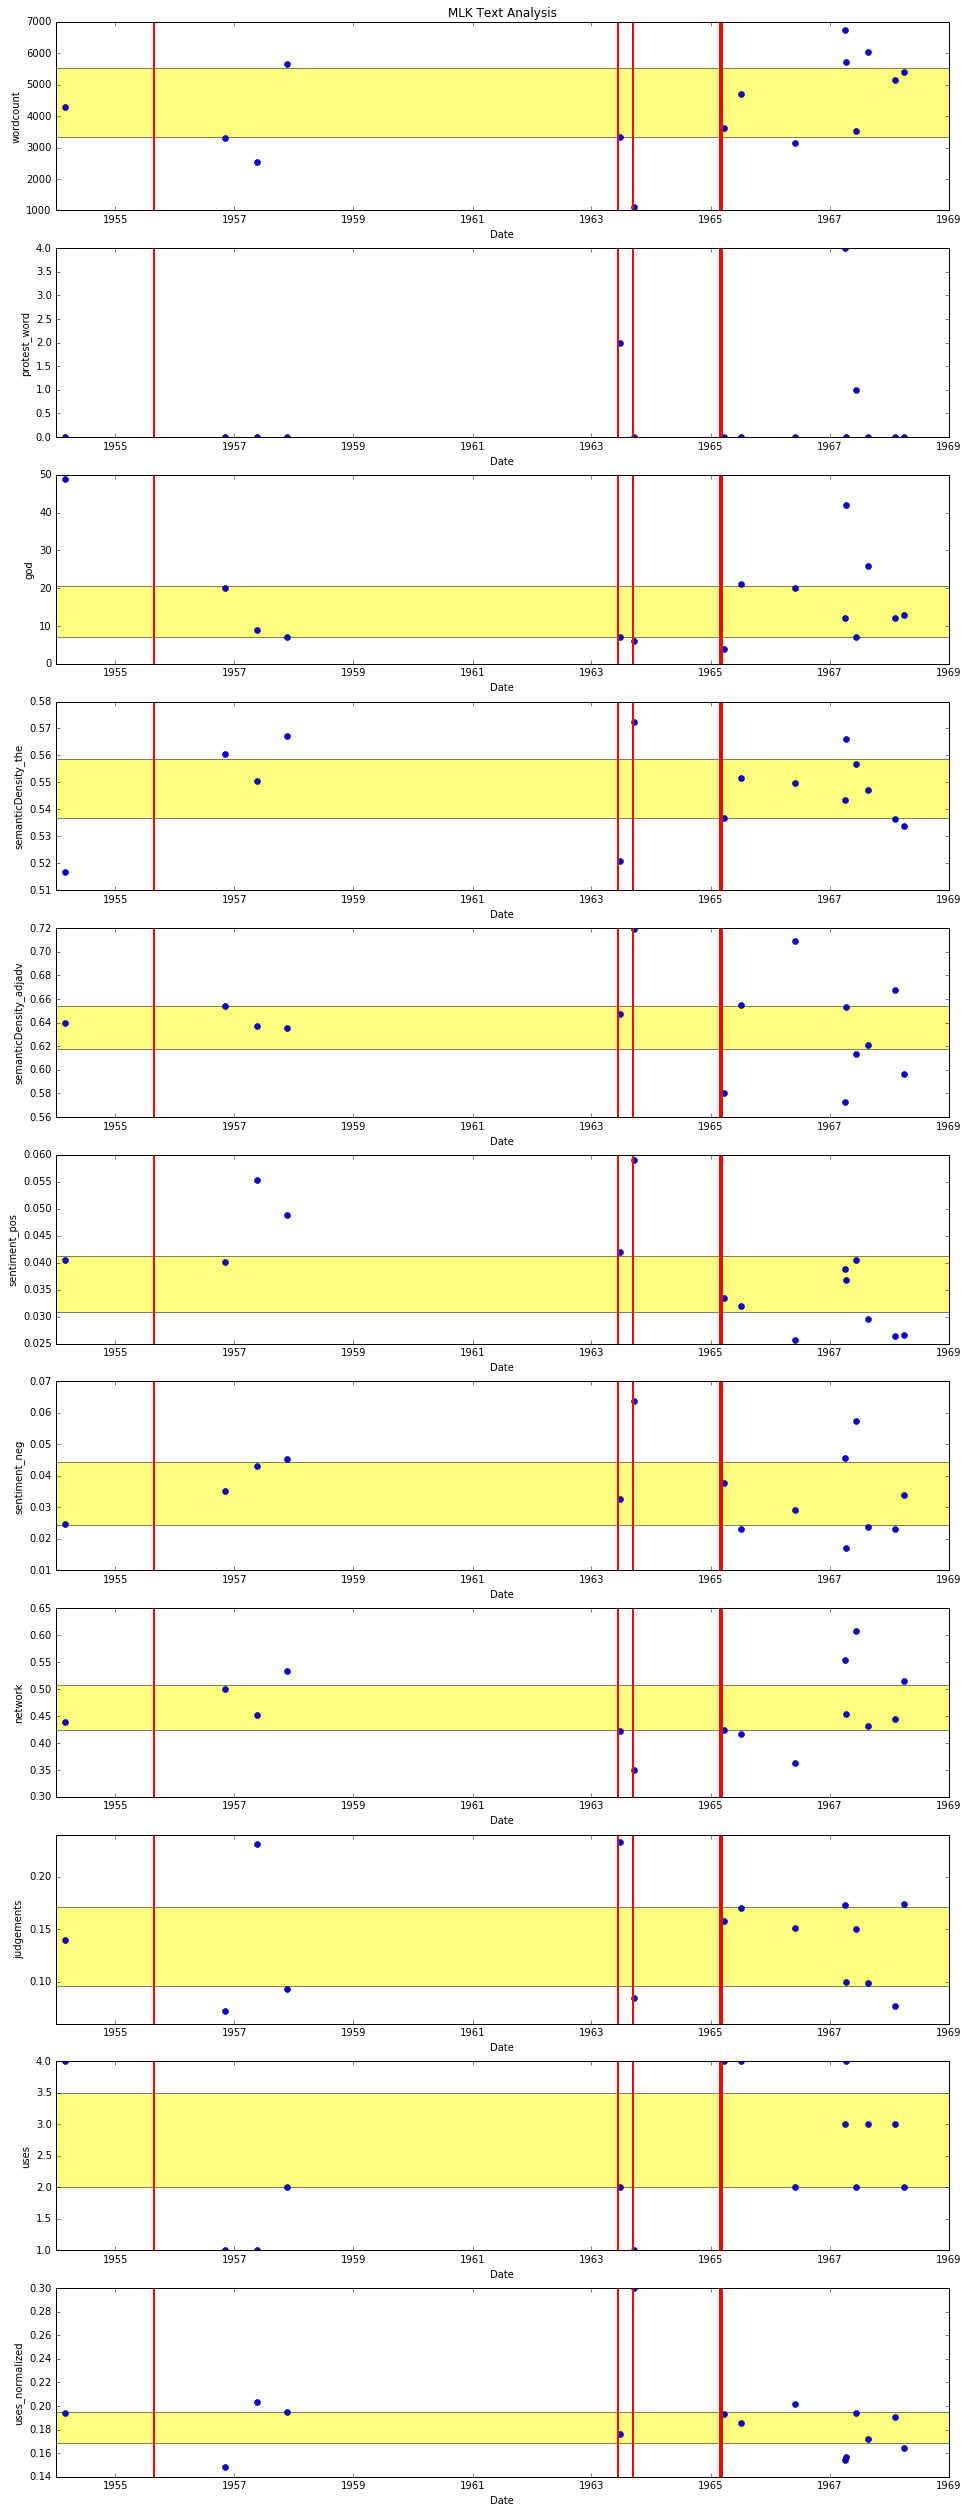

In [61]:
# Std parameters for each group defined at the top of the file
drawSignalPlots(fileData,fileData.columns,plotstart,plotend,group+'_temporal_all.pdf',d.Date,True)

1954-02-28 00:00:00 1968-03-31 00:00:00


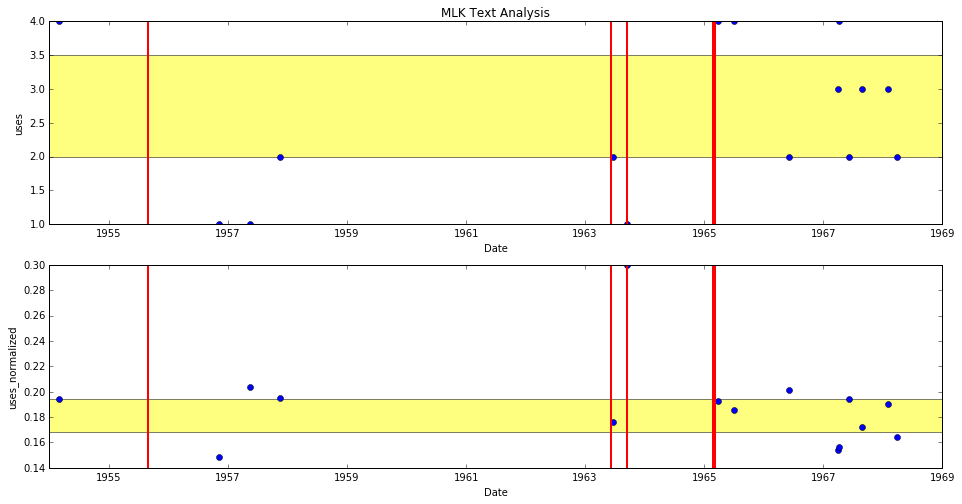

In [62]:
# Std parameters for each group defined at the top of the file
drawSignalPlots(fileData,['uses','uses_normalized'],plotstart,plotend,group+'_temporal_uses.pdf',d.Date,True)

### Draw plot with all signals on one graph, standardize the scale of the different signals

In [63]:
min_max_scaler = preprocessing.MinMaxScaler()

In [64]:
# Par Plot for all Signals in DF
def drawStdSignalPlots(fileData, signals, start_date, end_date, filename, events, save):
    
    signals = [var for var in signals if var not in ['fileName', 'date', 'date_clean']]

    # Standardize the Signals
    fd_normalized = fileData[['fileName','date_clean']]
    for signal in signals:
        fd_normalized[signal] = min_max_scaler.fit_transform(fileData[signal])  
        
    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

    i = 1
    for signal in signals:
        # plt.subplot(len(signals), 1, i)
        plt.plot(fd_normalized.date_clean, fd_normalized[signal], '-', marker='o')
        # [plt.axvline(event, color = 'red', lw=2) for event in d.Date]
        [plt.axvline(e, color = 'red', lw=2) for e in events]
        # plt.plot(fd_normalized.date_clean, fd_normalized.semanticDensity)
        plt.ylabel('Normalized Signal')
        plt.xlabel("Date")
        if i == 1:
            plt.title(group+' Text Analysis')
        #plt.axhline(fd_normalized.god.mean(), color = 'green')
        # plt.axhspan(fd_normalized[signal].quantile(0.25), fd_normalized[signal].quantile(0.75), \
        #     facecolor='yellow', alpha=0.5)
        plt.xlim([start_date,end_date])
        i += 1
        plt.legend(loc='best', fancybox=True, framealpha=0.5)
    if save:
        plt.savefig('./protest_temporalAnalysis/'+filename)
    plt.show()
    
    # return fd_normalized

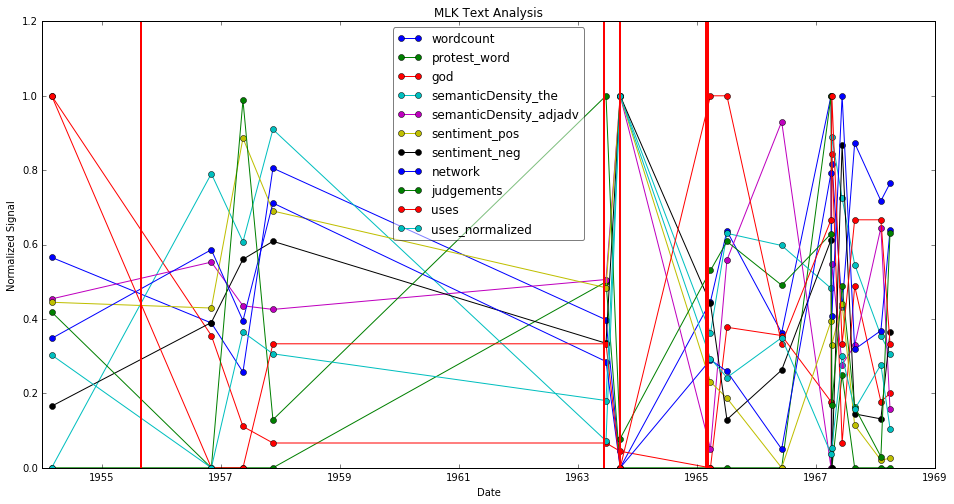

In [65]:
drawStdSignalPlots(fileData,fileData.columns,plotstart,plotend,group+'_std_all.pdf',d.Date,True)

In [66]:
fileData[['uses','uses_normalized']]

,uses,uses_normalized
7,4,0.194376
12,1,0.148465
1,1,0.203718
2,2,0.194852
4,2,0.175841
3,1,0.299848
5,4,0.192915
11,4,0.185196
13,2,0.201417
9,3,0.154120


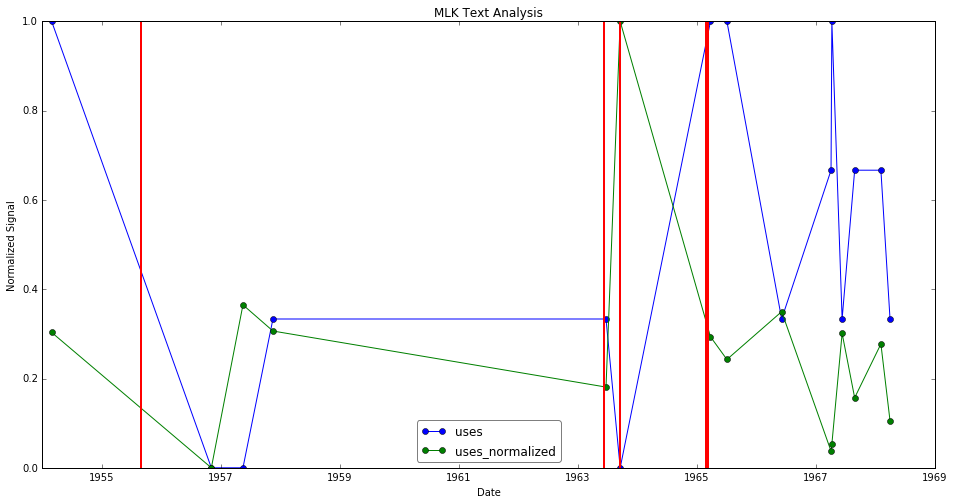

In [67]:
drawStdSignalPlots(fileData,['uses','uses_normalized'],plotstart,plotend,group+'_std_uses.pdf',d.Date,True)

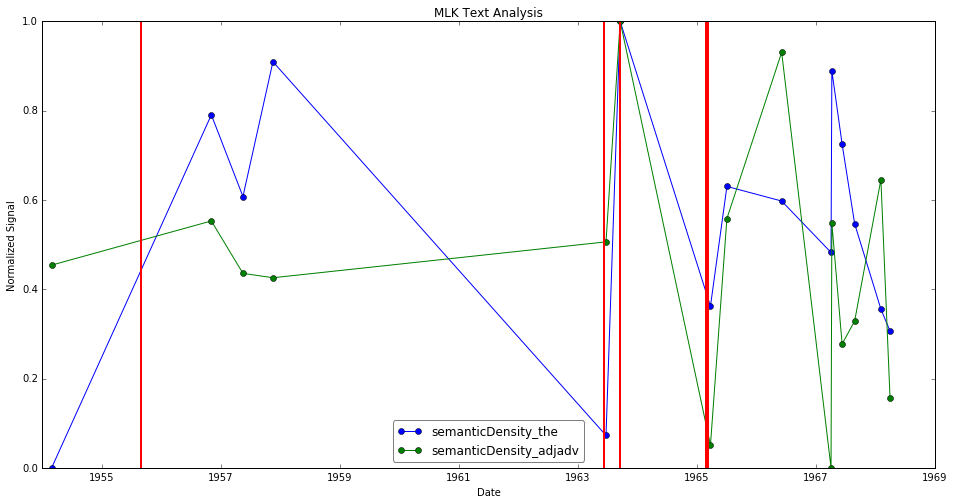

In [68]:
drawStdSignalPlots(fileData,['semanticDensity_the','semanticDensity_adjadv'],plotstart,plotend,group+'_std_semDensity.pdf',d.Date,True)

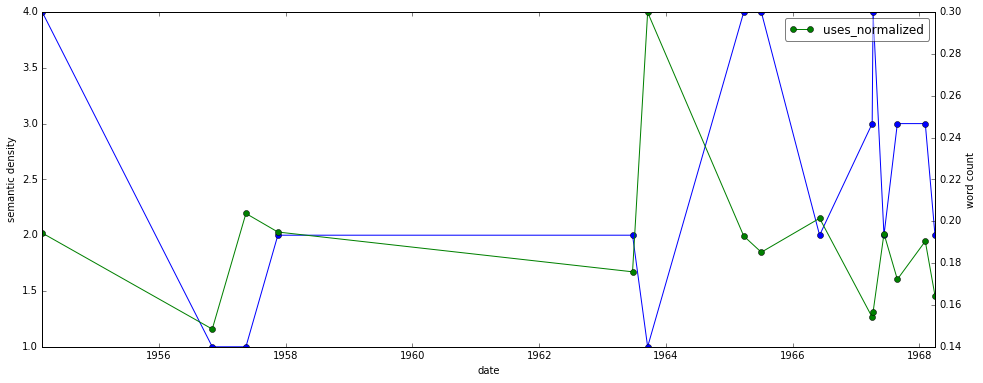

In [69]:
# Plotting w/ 2 Y-Scales
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(111)
ax1.plot(fileData.date_clean, fileData.uses, marker='o')
ax1.set_xlabel('date')
ax1.set_ylabel('semantic density')

ax2 = ax1.twinx()
ax2.plot(fileData.date_clean, fileData.uses_normalized, 'green', marker='o')
ax2.set_ylabel('word count')

plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.show()